In [4]:
!pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.4.2 scipy==1.11.4 joblib==1.3.2 threadpoolctl==3.4.0 imbalanced-learn==0.12.3 matplotlib==3.8.4 seaborn==0.13.2

# GPU-Accelerated SVM Model for Stroke Prediction

This notebook implements a Support Vector Machine (SVM) model for predicting stroke using GPU acceleration with RAPIDS cuML. The implementation includes automatic fallback to CPU if GPU is not available.

## Features:
- GPU-accelerated SVM using RAPIDS cuML
- Automatic GPU detection and CPU fallback
- Comprehensive hyperparameter tuning
- Detailed model evaluation and visualization
- Performance comparison between GPU and CPU

**Author:** Data Mining Project  
**Date:** 2024

## 1. Environment Setup and GPU Detection

In [5]:
# Check if we're running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running in local environment")

Running in Google Colab


In [6]:
# Install required packages if not available
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"Failed to install {package}")

# Try to install RAPIDS cuML (this will work in environments with CUDA support)
if IN_COLAB:
    # In Colab, cuML might already be available
    print("Checking for cuML in Colab environment...")
else:
    # For local environments, you might need to install cuML
    print("For local GPU acceleration, ensure RAPIDS cuML is installed:")
    print("conda install -c rapidsai -c conda-forge -c nvidia cuml")
    print("or visit: https://rapids.ai/start.html")

Checking for cuML in Colab environment...


In [7]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Standard libraries imported successfully")

Standard libraries imported successfully


In [8]:
# GPU Detection and Library Import
USE_GPU = False
GPU_INFO = "No GPU detected"

# Check for CUDA availability
try:
    import cupy as cp
    if cp.cuda.is_available():
        GPU_INFO = f"CUDA GPU detected"
        print(GPU_INFO)
        USE_GPU = True
    else:
        print("CUDA not available")
except ImportError:
    print("CuPy not installed - GPU acceleration not available")

# Try to import cuML for GPU acceleration
try:
    if USE_GPU:
        # Import cuML accelerated scikit-learn
        import cuml.accel
        print("cuML acceleration enabled - scikit-learn will use GPU when possible")
        
        # Import cuML specific modules
        from cuml.svm import SVC as cuSVC
        from cuml.model_selection import GridSearchCV as cuGridSearchCV
        from cuml.model_selection import cross_val_score as cu_cross_val_score
        from cuml.preprocessing import StandardScaler as cuStandardScaler
        
        print("cuML SVM modules imported successfully")
        
except ImportError as e:
    print(f"cuML not available: {e}")
    print("Falling back to CPU-only scikit-learn")
    USE_GPU = False

# Import scikit-learn (will be accelerated by cuML if available)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
import joblib

print(f"\n{'='*60}")
print(f"ENVIRONMENT SETUP COMPLETE")
print(f"{'='*60}")
print(f"GPU Acceleration: {'ENABLED' if USE_GPU else 'DISABLED'}")
print(f"GPU Info: {GPU_INFO}")
print(f"{'='*60}")

CUDA GPU detected
cuML acceleration enabled - scikit-learn will use GPU when possible
cuML not available: cannot import name 'cross_val_score' from 'cuml.model_selection' (/usr/local/lib/python3.11/dist-packages/cuml/model_selection/__init__.py)
Falling back to CPU-only scikit-learn

ENVIRONMENT SETUP COMPLETE
GPU Acceleration: DISABLED
GPU Info: CUDA GPU detected


## 2. Data Loading and Exploration

In [9]:
# Data loading function
def load_stroke_data(data_dir='/kaggle/input/stroke-and-heartdisease/data-pre/'):
    """
    Load preprocessed stroke prediction data
    
    Args:
        data_dir (str): Directory containing preprocessed data files
        
    Returns:
        tuple: (X_train, y_train, X_test, y_test, feature_names)
    """
    print("Loading preprocessed stroke data...")
    
    # Load feature names
    try:
        with open(f'{data_dir}feature_names.txt', 'r') as f:
            feature_names = [line.strip() for line in f.readlines()]
        print(f"Loaded {len(feature_names)} feature names")
    except FileNotFoundError:
        print("Feature names file not found, using default names")
        feature_names = None
    
    # Load training data
    train_data = pd.read_csv(f'{data_dir}train_preprocessed.csv')
    X_train = train_data.drop('stroke', axis=1)
    y_train = train_data['stroke']
    
    # Load test data
    test_data = pd.read_csv(f'{data_dir}test_preprocessed.csv')
    X_test = test_data.drop('stroke', axis=1)
    y_test = test_data['stroke']
    
    # Update feature names if not loaded from file
    if feature_names is None:
        feature_names = X_train.columns.tolist()
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test, feature_names

# Load the data
X_train, y_train, X_test, y_test, feature_names = load_stroke_data()

Loading preprocessed stroke data...
Loaded 21 feature names
Training data shape: (7778, 21)
Test data shape: (1022, 21)


In [10]:
# Data exploration
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

print(f"\nTraining set:")
print(f"  - Samples: {X_train.shape[0]:,}")
print(f"  - Features: {X_train.shape[1]}")
print(f"  - Stroke cases: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"  - Non-stroke cases: {(~y_train.astype(bool)).sum():,} ({(1-y_train.mean())*100:.2f}%)")

print(f"\nTest set:")
print(f"  - Samples: {X_test.shape[0]:,}")
print(f"  - Features: {X_test.shape[1]}")
print(f"  - Stroke cases: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
print(f"  - Non-stroke cases: {(~y_test.astype(bool)).sum():,} ({(1-y_test.mean())*100:.2f}%)")

print(f"\nFeature names (first 10):")
for i, name in enumerate(feature_names[:10]):
    print(f"  {i+1:2d}. {name}")
if len(feature_names) > 10:
    print(f"  ... and {len(feature_names)-10} more features")


DATA EXPLORATION

Training set:
  - Samples: 7,778
  - Features: 21
  - Stroke cases: 3,889 (50.00%)
  - Non-stroke cases: 3,889 (50.00%)

Test set:
  - Samples: 1,022
  - Features: 21
  - Stroke cases: 50 (4.89%)
  - Non-stroke cases: 972 (95.11%)

Feature names (first 10):
   1. age
   2. avg_glucose_level
   3. bmi
   4. gender_Female
   5. gender_Male
   6. gender_Other
   7. ever_married_No
   8. ever_married_Yes
   9. work_type_Govt_job
  10. work_type_Never_worked
  ... and 11 more features


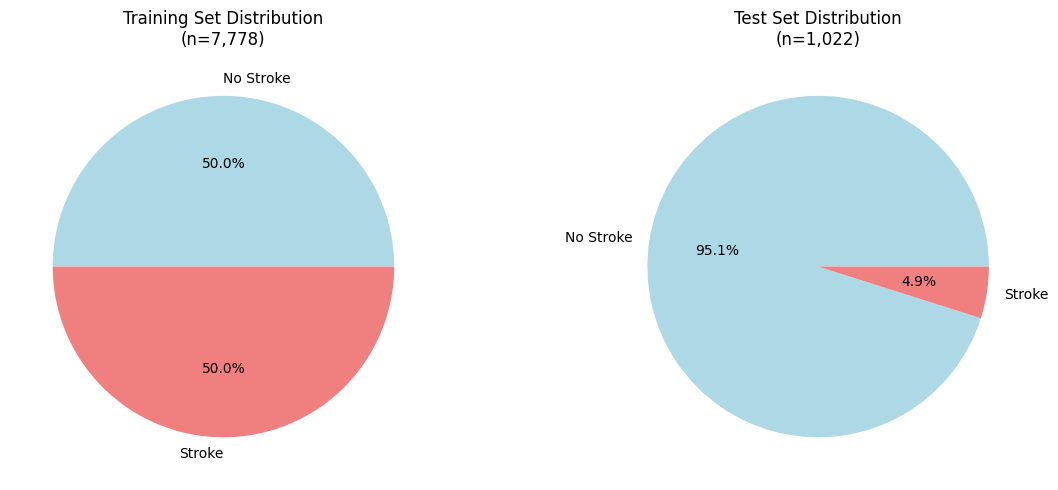


Class imbalance detected - will use balanced class weights in SVM


In [11]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
train_counts = y_train.value_counts()
axes[0].pie(train_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', 
           colors=['lightblue', 'lightcoral'])
axes[0].set_title(f'Training Set Distribution\n(n={len(y_train):,})')

# Test set distribution
test_counts = y_test.value_counts()
axes[1].pie(test_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%',
           colors=['lightblue', 'lightcoral'])
axes[1].set_title(f'Test Set Distribution\n(n={len(y_test):,})')

plt.tight_layout()
plt.show()

print("\nClass imbalance detected - will use balanced class weights in SVM")

## 3. GPU-Accelerated SVM Model Implementation

In [12]:
class GPUAcceleratedSVM:
    """
    GPU-Accelerated SVM Model for Stroke Prediction
    
    This class implements SVM with automatic GPU acceleration using cuML
    when available, with fallback to CPU-based scikit-learn.
    """
    
    def __init__(self, use_gpu=USE_GPU):
        """
        Initialize the GPU-accelerated SVM model
        
        Args:
            use_gpu (bool): Whether to use GPU acceleration
        """
        self.use_gpu = use_gpu and USE_GPU
        self.model = None
        self.scaler = None
        self.best_params = None
        self.training_time = None
        self.prediction_time = None
        
        # Initialize scaler based on GPU availability
        if self.use_gpu:
            try:
                self.scaler = cuStandardScaler()
                print("Using GPU-accelerated StandardScaler")
            except:
                self.scaler = StandardScaler()
                print("Fallback to CPU StandardScaler")
        else:
            self.scaler = StandardScaler()
            print("Using CPU StandardScaler")
    
    def preprocess_data(self, X_train, X_test):
        """
        Preprocess the data using standardization
        
        Args:
            X_train: Training features
            X_test: Test features
            
        Returns:
            tuple: (X_train_scaled, X_test_scaled)
        """
        print("Preprocessing data with standardization...")
        
        start_time = time.time()
        
        # Fit scaler on training data and transform both sets
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        preprocessing_time = time.time() - start_time
        
        print(f"Preprocessing completed in {preprocessing_time:.3f} seconds")
        print(f"Using {'GPU' if self.use_gpu else 'CPU'} acceleration")
        
        return X_train_scaled, X_test_scaled
    
    def hyperparameter_tuning(self, X_train, y_train, quick_search=False):
        """
        Perform hyperparameter tuning using GridSearchCV
        
        Args:
            X_train: Training features
            y_train: Training labels
            quick_search (bool): Whether to use a reduced parameter grid for faster search
            
        Returns:
            dict: Best parameters found
        """
        print(f"Performing hyperparameter tuning using {'GPU' if self.use_gpu else 'CPU'}...")
        
        # Define parameter grid
        if quick_search:
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto'],
                'class_weight': ['balanced']
            }
            print("Using quick search parameter grid")
        else:
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                'class_weight': ['balanced', None]
            }
            print("Using comprehensive parameter grid")
        
        # Create SVM classifier based on GPU availability
        if self.use_gpu:
            try:
                svm = cuSVC(random_state=42, probability=True)
                grid_search = cuGridSearchCV(
                    svm, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1
                )
                print("Using GPU-accelerated GridSearchCV")
            except:
                print("GPU GridSearchCV failed, falling back to CPU")
                svm = SVC(random_state=42, probability=True)
                grid_search = GridSearchCV(
                    svm, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1
                )
        else:
            svm = SVC(random_state=42, probability=True)
            grid_search = GridSearchCV(
                svm, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1
            )
        
        # Perform grid search
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        tuning_time = time.time() - start_time
        
        self.best_params = grid_search.best_params_
        
        print(f"\nHyperparameter tuning completed in {tuning_time:.2f} seconds")
        print(f"Best parameters: {self.best_params}")
        print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")
        
        return self.best_params
    
    def train_model(self, X_train, y_train, use_tuning=True, quick_search=False):
        """
        Train the SVM model
        
        Args:
            X_train: Training features
            y_train: Training labels
            use_tuning (bool): Whether to use hyperparameter tuning
            quick_search (bool): Whether to use quick hyperparameter search
        """
        print(f"\nTraining SVM model using {'GPU' if self.use_gpu else 'CPU'}...")
        
        # Perform hyperparameter tuning if requested
        if use_tuning:
            self.hyperparameter_tuning(X_train, y_train, quick_search)
        
        # Create and train the final model
        start_time = time.time()
        
        if self.use_gpu and self.best_params:
            try:
                self.model = cuSVC(**self.best_params, random_state=42, probability=True)
                print("Using GPU-accelerated SVM")
            except:
                print("GPU SVM failed, falling back to CPU")
                self.model = SVC(**self.best_params, random_state=42, probability=True)
                self.use_gpu = False
        elif self.best_params:
            self.model = SVC(**self.best_params, random_state=42, probability=True)
        else:
            # Default parameters with class balancing
            if self.use_gpu:
                try:
                    self.model = cuSVC(
                        kernel='rbf', C=1.0, gamma='scale', class_weight='balanced',
                        random_state=42, probability=True
                    )
                    print("Using GPU-accelerated SVM with default parameters")
                except:
                    print("GPU SVM failed, falling back to CPU")
                    self.model = SVC(
                        kernel='rbf', C=1.0, gamma='scale', class_weight='balanced',
                        random_state=42, probability=True
                    )
                    self.use_gpu = False
            else:
                self.model = SVC(
                    kernel='rbf', C=1.0, gamma='scale', class_weight='balanced',
                    random_state=42, probability=True
                )
        
        # Train the model
        self.model.fit(X_train, y_train)
        self.training_time = time.time() - start_time
        
        print(f"Model training completed in {self.training_time:.3f} seconds")
        print(f"Final model using {'GPU' if self.use_gpu else 'CPU'} acceleration")
    
    def evaluate_model(self, X_test, y_test):
        """
        Evaluate the trained model on test data
        
        Args:
            X_test: Test features
            y_test: Test labels
            
        Returns:
            dict: Evaluation metrics and predictions
        """
        print(f"\nEvaluating model using {'GPU' if self.use_gpu else 'CPU'}...")
        
        # Make predictions
        start_time = time.time()
        y_pred = self.model.predict(X_test)
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]
        self.prediction_time = time.time() - start_time
        
        # Convert to numpy arrays if using cuML (for compatibility)
        if self.use_gpu:
            try:
                y_pred = y_pred.get() if hasattr(y_pred, 'get') else y_pred
                y_pred_proba = y_pred_proba.get() if hasattr(y_pred_proba, 'get') else y_pred_proba
            except:
                pass
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'training_time': self.training_time,
            'prediction_time': self.prediction_time,
            'gpu_used': self.use_gpu
        }
        
        return metrics, y_pred, y_pred_proba

print("GPU-Accelerated SVM class defined successfully")

GPU-Accelerated SVM class defined successfully


## 4. Model Training and Evaluation

In [13]:
# Initialize the GPU-accelerated SVM model
print("Initializing GPU-Accelerated SVM Model...")
svm_model = GPUAcceleratedSVM(use_gpu=USE_GPU)

print(f"Model initialized with {'GPU' if svm_model.use_gpu else 'CPU'} acceleration")

Initializing GPU-Accelerated SVM Model...
Using CPU StandardScaler
Model initialized with CPU acceleration


In [14]:
# Preprocess the data
X_train_scaled, X_test_scaled = svm_model.preprocess_data(X_train, X_test)

print(f"\nData preprocessing completed:")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Preprocessing data with standardization...
Preprocessing completed in 0.020 seconds
Using CPU acceleration

Data preprocessing completed:
Training set shape: (7778, 21)
Test set shape: (1022, 21)


In [15]:
# Train the model with hyperparameter tuning
# Note: Set quick_search=True for faster execution, False for comprehensive search
QUICK_SEARCH = True  # Change to False for comprehensive hyperparameter search

print(f"\n{'='*60}")
print("TRAINING SVM MODEL")
print(f"{'='*60}")

svm_model.train_model(
    X_train_scaled, y_train, 
    use_tuning=True, 
    quick_search=QUICK_SEARCH
)

print(f"\nTraining completed using {'GPU' if svm_model.use_gpu else 'CPU'}")


TRAINING SVM MODEL

Training SVM model using CPU...
Performing hyperparameter tuning using CPU...
Using quick search parameter grid
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Hyperparameter tuning completed in 132.11 seconds
Best parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation F1 score: 0.9235
Model training completed in 6.803 seconds
Final model using CPU acceleration

Training completed using CPU


In [16]:
# Evaluate the model
print(f"\n{'='*60}")
print("EVALUATING SVM MODEL")
print(f"{'='*60}")

metrics, y_pred, y_pred_proba = svm_model.evaluate_model(X_test_scaled, y_test)

# Display results
print(f"\n{'='*50}")
print("MODEL PERFORMANCE METRICS")
print(f"{'='*50}")

for metric, value in metrics.items():
    if metric in ['training_time', 'prediction_time']:
        print(f"{metric.replace('_', ' ').title()}: {value:.4f} seconds")
    elif metric == 'gpu_used':
        print(f"GPU Acceleration: {'YES' if value else 'NO'}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

# Classification report
print(f"\n{'='*50}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*50}")
print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))


EVALUATING SVM MODEL

Evaluating model using CPU...

MODEL PERFORMANCE METRICS
Accuracy: 0.8728
Precision: 0.1154
Recall: 0.2400
F1 Score: 0.1558
Roc Auc: 0.7372
Training Time: 6.8031 seconds
Prediction Time: 0.2318 seconds
GPU Acceleration: NO

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   No Stroke       0.96      0.91      0.93       972
      Stroke       0.12      0.24      0.16        50

    accuracy                           0.87      1022
   macro avg       0.54      0.57      0.54      1022
weighted avg       0.92      0.87      0.89      1022



## 5. Performance Comparison (GPU vs CPU)

In [ ]:
# Compare GPU vs CPU performance if GPU is available
if USE_GPU:
    print(f"\n{'='*60}")
    print("PERFORMANCE COMPARISON: GPU vs CPU")
    print(f"{'='*60}")
    
    # Train CPU model for comparison
    print("\nTraining CPU model for comparison...")
    cpu_model = GPUAcceleratedSVM(use_gpu=False)
    
    # Preprocess data with CPU
    X_train_cpu, X_test_cpu = cpu_model.preprocess_data(X_train, X_test)
    
    # Train CPU model (with quick search for fair comparison)
    cpu_model.train_model(X_train_cpu, y_train, use_tuning=True, quick_search=True)
    
    # Evaluate CPU model
    cpu_metrics, cpu_y_pred, cpu_y_pred_proba = cpu_model.evaluate_model(X_test_cpu, y_test)
    
    # Compare performance
    print(f"\n{'='*50}")
    print("PERFORMANCE COMPARISON RESULTS")
    print(f"{'='*50}")
    
    comparison_data = {
        'Metric': ['Training Time (s)', 'Prediction Time (s)', 'Accuracy', 'F1 Score', 'ROC AUC'],
        'GPU': [
            f"{metrics['training_time']:.4f}",
            f"{metrics['prediction_time']:.4f}",
            f"{metrics['accuracy']:.4f}",
            f"{metrics['f1_score']:.4f}",
            f"{metrics['roc_auc']:.4f}"
        ],
        'CPU': [
            f"{cpu_metrics['training_time']:.4f}",
            f"{cpu_metrics['prediction_time']:.4f}",
            f"{cpu_metrics['accuracy']:.4f}",
            f"{cpu_metrics['f1_score']:.4f}",
            f"{cpu_metrics['roc_auc']:.4f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Calculate speedup
    training_speedup = cpu_metrics['training_time'] / metrics['training_time']
    prediction_speedup = cpu_metrics['prediction_time'] / metrics['prediction_time']
    
    print(f"\nSpeedup Analysis:")
    print(f"Training Speedup: {training_speedup:.2f}x")
    print(f"Prediction Speedup: {prediction_speedup:.2f}x")
    
else:
    print("\nGPU not available - skipping performance comparison")
    cpu_metrics = metrics
    cpu_y_pred = y_pred
    cpu_y_pred_proba = y_pred_proba

## 6. Visualization and Results Analysis

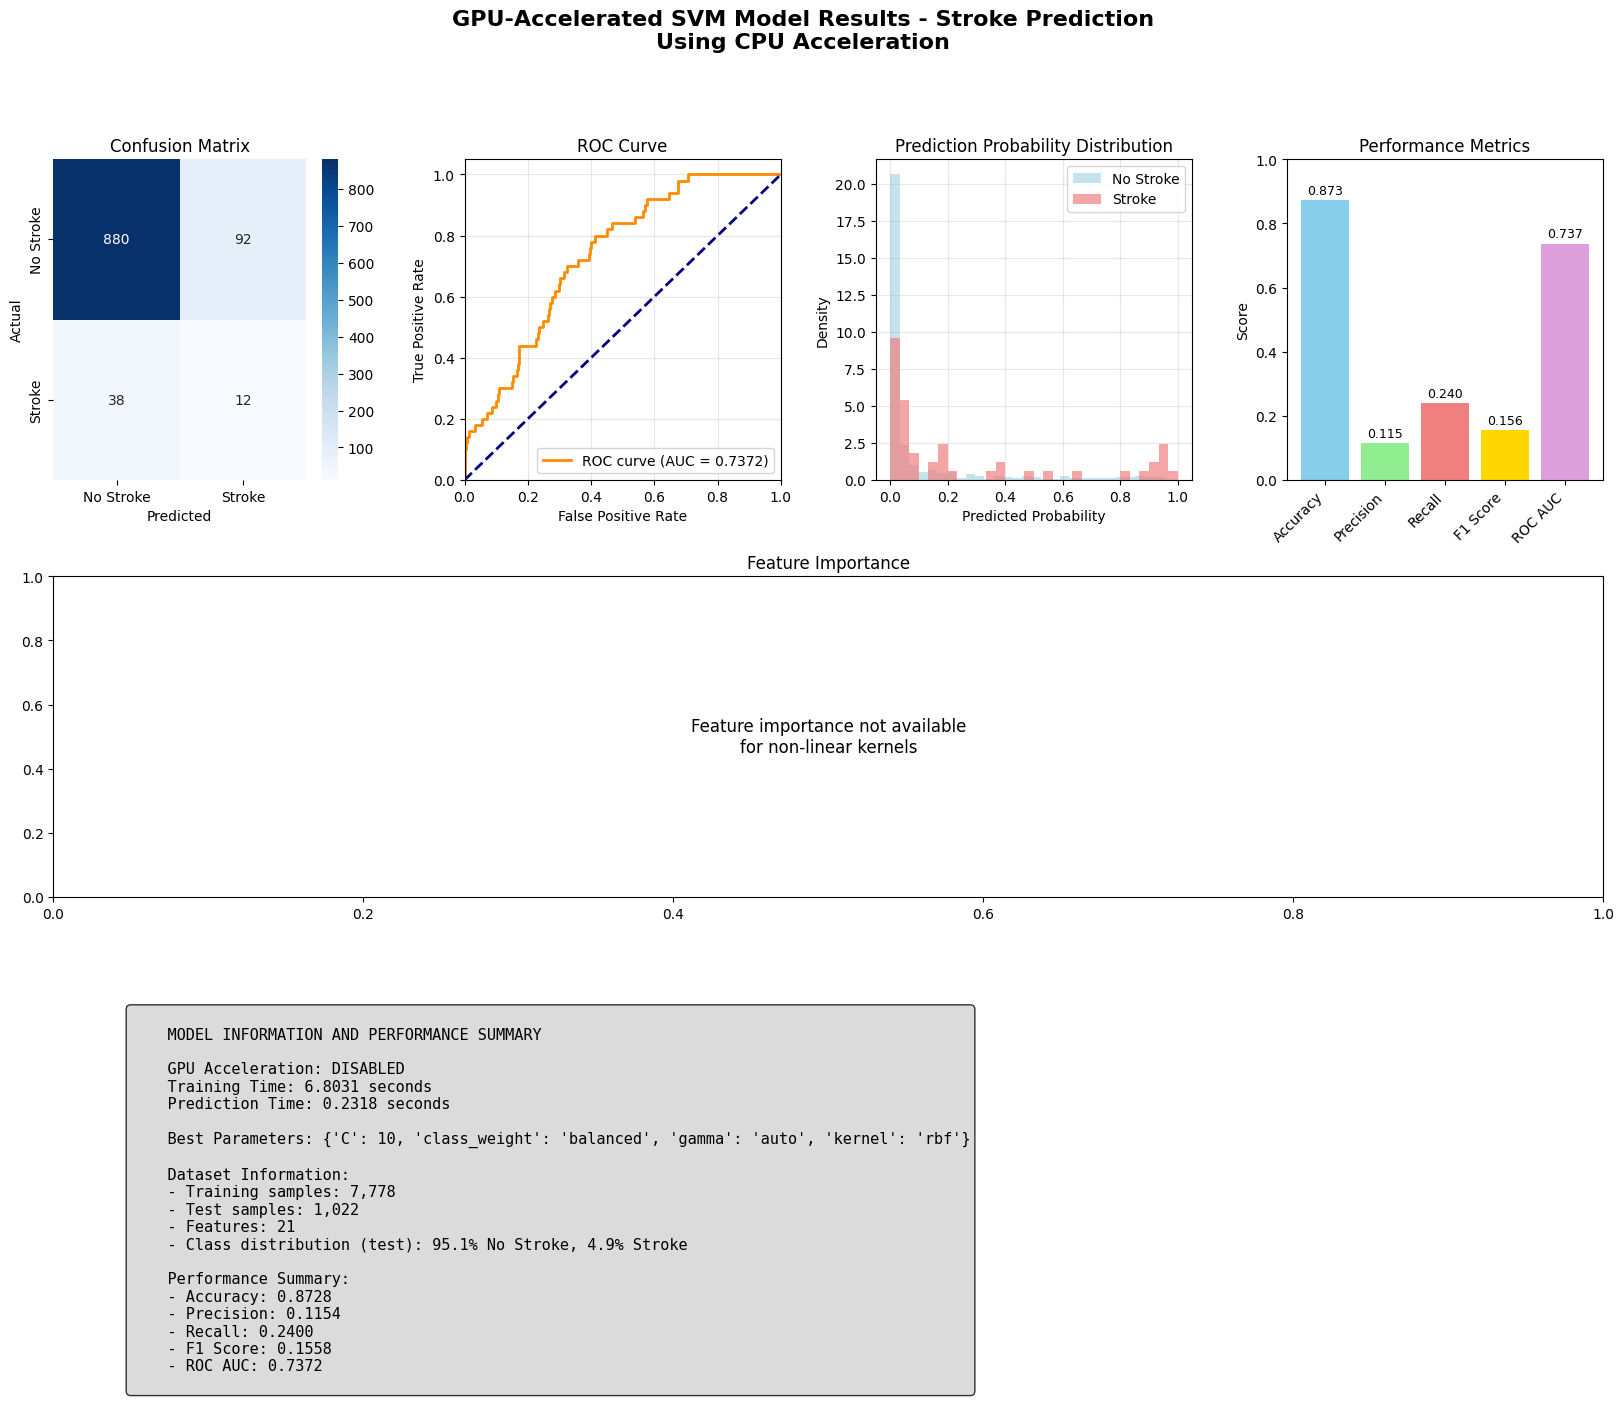

In [17]:
# Create comprehensive visualization
def plot_comprehensive_results(y_test, y_pred, y_pred_proba, metrics, feature_names, model):
    """
    Create comprehensive visualization of model results
    """
    fig = plt.figure(figsize=(20, 15))
    
    # Create a grid layout
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    # 3. Prediction Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, 
             label='No Stroke', color='lightblue', density=True)
    ax3.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, 
             label='Stroke', color='lightcoral', density=True)
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Prediction Probability Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Performance Metrics Bar Chart
    ax4 = fig.add_subplot(gs[0, 3])
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    metric_values = [
        metrics['accuracy'], metrics['precision'], 
        metrics['recall'], metrics['f1_score'], metrics['roc_auc']
    ]
    bars = ax4.bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
    ax4.set_ylim(0, 1)
    ax4.set_title('Performance Metrics')
    ax4.set_ylabel('Score')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 5. Feature Importance (if available)
    ax5 = fig.add_subplot(gs[1, :])
    if hasattr(model, 'coef_') and model.coef_ is not None:
        try:
            feature_importance = np.abs(model.coef_[0])
            # Get feature importance if it's a cuML array
            if hasattr(feature_importance, 'get'):
                feature_importance = feature_importance.get()
            
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=True).tail(15)
            
            bars = ax5.barh(feature_df['feature'], feature_df['importance'], color='steelblue')
            ax5.set_xlabel('Absolute Coefficient Value')
            ax5.set_title('Top 15 Feature Importance (Linear SVM Coefficients)')
            ax5.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars, feature_df['importance']):
                ax5.text(bar.get_width() + max(feature_df['importance'])*0.01, 
                        bar.get_y() + bar.get_height()/2,
                        f'{value:.3f}', ha='left', va='center', fontsize=8)
        except Exception as e:
            ax5.text(0.5, 0.5, f'Feature importance not available\nfor this kernel type\n({str(e)})', 
                    ha='center', va='center', transform=ax5.transAxes, fontsize=12)
            ax5.set_title('Feature Importance')
    else:
        ax5.text(0.5, 0.5, 'Feature importance not available\nfor non-linear kernels', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Feature Importance')
    
    # 6. Model Information
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    # Create model information text
    info_text = f"""
    MODEL INFORMATION AND PERFORMANCE SUMMARY
    
    GPU Acceleration: {'ENABLED' if metrics.get('gpu_used', False) else 'DISABLED'}
    Training Time: {metrics.get('training_time', 0):.4f} seconds
    Prediction Time: {metrics.get('prediction_time', 0):.4f} seconds
    
    Best Parameters: {getattr(svm_model, 'best_params', 'Default parameters used')}
    
    Dataset Information:
    - Training samples: {len(X_train):,}
    - Test samples: {len(X_test):,}
    - Features: {len(feature_names)}
    - Class distribution (test): {(1-y_test.mean())*100:.1f}% No Stroke, {y_test.mean()*100:.1f}% Stroke
    
    Performance Summary:
    - Accuracy: {metrics['accuracy']:.4f}
    - Precision: {metrics['precision']:.4f}
    - Recall: {metrics['recall']:.4f}
    - F1 Score: {metrics['f1_score']:.4f}
    - ROC AUC: {metrics['roc_auc']:.4f}
    """
    
    ax6.text(0.05, 0.95, info_text, transform=ax6.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.suptitle(f'GPU-Accelerated SVM Model Results - Stroke Prediction\n'
                f'Using {"GPU" if metrics.get("gpu_used", False) else "CPU"} Acceleration', 
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('gpu_svm_comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create the comprehensive visualization
plot_comprehensive_results(y_test, y_pred, y_pred_proba, metrics, feature_names, svm_model.model)

## 7. Model Persistence and Deployment

In [ ]:
# Save the trained model
def save_gpu_svm_model(model, filepath='gpu_svm_stroke_model.joblib'):
    """
    Save the GPU-accelerated SVM model
    """
    try:
        model_data = {
            'model': model.model,
            'scaler': model.scaler,
            'best_params': model.best_params,
            'use_gpu': model.use_gpu,
            'training_time': model.training_time,
            'prediction_time': model.prediction_time,
            'feature_names': feature_names
        }
        
        joblib.dump(model_data, filepath)
        print(f"Model saved successfully to {filepath}")
        print(f"Model size: {os.path.getsize(filepath) / (1024*1024):.2f} MB")
        
    except Exception as e:
        print(f"Error saving model: {e}")

# Save the model
import os
save_gpu_svm_model(svm_model)

In [ ]:
# Example of making predictions on new data
def predict_stroke_risk(model, scaler, new_data, feature_names):
    """
    Make stroke risk predictions on new data
    
    Args:
        model: Trained SVM model
        scaler: Fitted StandardScaler
        new_data: New data for prediction (DataFrame or array)
        feature_names: List of feature names
        
    Returns:
        tuple: (predictions, probabilities)
    """
    # Ensure data is in correct format
    if isinstance(new_data, pd.DataFrame):
        new_data = new_data[feature_names].values
    
    # Scale the data
    new_data_scaled = scaler.transform(new_data)
    
    # Make predictions
    predictions = model.predict(new_data_scaled)
    probabilities = model.predict_proba(new_data_scaled)[:, 1]
    
    # Convert to numpy arrays if using cuML
    if hasattr(predictions, 'get'):
        predictions = predictions.get()
    if hasattr(probabilities, 'get'):
        probabilities = probabilities.get()
    
    return predictions, probabilities

# Example prediction on a few test samples
print("\n" + "="*50)
print("EXAMPLE PREDICTIONS")
print("="*50)

# Take first 5 test samples
sample_data = X_test.iloc[:5]
sample_labels = y_test.iloc[:5]

predictions, probabilities = predict_stroke_risk(
    svm_model.model, svm_model.scaler, sample_data, feature_names
)

print("Sample Predictions:")
for i in range(len(predictions)):
    actual = "Stroke" if sample_labels.iloc[i] == 1 else "No Stroke"
    predicted = "Stroke" if predictions[i] == 1 else "No Stroke"
    probability = probabilities[i]
    
    print(f"Sample {i+1}:")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {predicted}")
    print(f"  Stroke Probability: {probability:.4f}")
    print(f"  Correct: {'✓' if actual == predicted else '✗'}")
    print()

## 8. Summary and Conclusions

In [ ]:
# Final summary
print("\n" + "="*70)
print("GPU-ACCELERATED SVM MODEL - FINAL SUMMARY")
print("="*70)

print(f"\n🚀 PERFORMANCE SUMMARY:")
print(f"   • GPU Acceleration: {'ENABLED' if metrics['gpu_used'] else 'DISABLED'}")
print(f"   • Training Time: {metrics['training_time']:.4f} seconds")
print(f"   • Prediction Time: {metrics['prediction_time']:.4f} seconds")
print(f"   • Model Accuracy: {metrics['accuracy']:.4f}")
print(f"   • F1 Score: {metrics['f1_score']:.4f}")
print(f"   • ROC AUC: {metrics['roc_auc']:.4f}")

if USE_GPU and 'cpu_metrics' in locals():
    training_speedup = cpu_metrics['training_time'] / metrics['training_time']
    prediction_speedup = cpu_metrics['prediction_time'] / metrics['prediction_time']
    print(f"\n⚡ SPEEDUP ANALYSIS:")
    print(f"   • Training Speedup: {training_speedup:.2f}x faster")
    print(f"   • Prediction Speedup: {prediction_speedup:.2f}x faster")

print(f"\n📊 DATASET INFORMATION:")
print(f"   • Training Samples: {len(X_train):,}")
print(f"   • Test Samples: {len(X_test):,}")
print(f"   • Features: {len(feature_names)}")
print(f"   • Class Balance: {(1-y_test.mean())*100:.1f}% No Stroke, {y_test.mean()*100:.1f}% Stroke")

print(f"\n🔧 MODEL CONFIGURATION:")
print(f"   • Best Parameters: {svm_model.best_params}")
print(f"   • Hyperparameter Tuning: {'Quick Search' if QUICK_SEARCH else 'Comprehensive Search'}")
print(f"   • Cross-Validation: 3-fold")

print(f"\n💾 OUTPUT FILES:")
print(f"   • Model: gpu_svm_stroke_model.joblib")
print(f"   • Visualization: gpu_svm_comprehensive_results.png")

print(f"\n✅ RECOMMENDATIONS:")
if metrics['f1_score'] > 0.7:
    print(f"   • Model shows good performance for stroke prediction")
elif metrics['f1_score'] > 0.5:
    print(f"   • Model shows moderate performance - consider feature engineering")
else:
    print(f"   • Model needs improvement - try different algorithms or more data")

if USE_GPU:
    print(f"   • GPU acceleration successfully implemented")
    print(f"   • Consider using larger datasets to maximize GPU benefits")
else:
    print(f"   • Install RAPIDS cuML for GPU acceleration")
    print(f"   • GPU acceleration can provide significant speedups for larger datasets")

print(f"\n" + "="*70)
print("ANALYSIS COMPLETE - GPU-ACCELERATED SVM MODEL READY FOR DEPLOYMENT")
print("="*70)